**Akash Sharma (EE21S056)**

**EE5179: Deep Learning for Imaging**

# MNIST classification using CNN

## Preliminaries

### Importing required packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import sys
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

### Loading dataset

In [2]:
dset_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = torchvision.datasets.MNIST(root="data/", train=True, transform= dset_transform, download=True)
test_dset = torchvision.datasets.MNIST(root="data/", train=False, transform= dset_transform, download=True)

In the above code cell, training and testing MNIST datasets have been called. However in the assignment, an additional condition has been imposed i.e., the train, test and validation split should have equal representation from all $10$ classes of images. To this end, we use [**stratified split**](https://scikit-learn.org/stable/modules/cross_validation.html#stratification) on `train_dset` into training and validation splits. This ensures that all the classes are equally represented in `train_dset` and `val_dset`. This approach has not been applied to impose this condition on `test_dset` as it is assumed that it follows this condition already. 

Since `PyTorch` does not have a straightforward method for a stratified split, `sklearn` has been used for the same. 

In [3]:
# https://discuss.pytorch.org/t/does-torch-utils-data-random-split-split-every-class-equally/43517
# https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290?msclkid=cdbabbe8c1bb11ecbfa1268a15c4fbd4

train_targets = train_dset.targets

# Split indices using stratify
train_idx, val_idx = train_test_split(np.arange(len(train_targets)), test_size=0.1, shuffle = True, stratify = train_targets)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dset, batch_size=100, sampler = train_sampler)
val_loader = DataLoader(train_dset, batch_size = 100, sampler = val_sampler)
test_loader = DataLoader(test_dset, batch_size = 100, shuffle = False)

## Model Training and Testing

Defining the CNN for MNIST classification as per the architecture prescribed in the assignment. Another alternative implementation is available on https://github.com/pytorch/examples/blob/main/mnist/main.py which utilises negative likelihood loss as opposed to cross entropy loss that is being used here.

### CNN Architecture Definition

In [4]:
class convNet(nn.Module):
  def __init__(self):
    super(convNet, self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(32,32,kernel_size = 3, stride = 1, padding = 1)
    self.fc1   = nn.Linear(7*7*32, 500)
    self.fc2   = nn.Linear(500, 10)
    self.activ = nn.ReLU()

  def pool(self, x, kernel_size = 2, stride = 2):
    out = F.max_pool2d(x, kernel_size, stride)
    return out

  def forward(self, x, softmax = True):
    out = self.activ(self.conv1(x))
    out = self.pool(out)
    out = self.activ(self.conv2(out))
    out = self.pool(out)
    out = out.view(out.size(0),-1)
    out = self.activ(self.fc1(out))
    out = self.fc2(out)
    if softmax:
      return F.softmax(out, dim = 1)
    else:
      return out

### Utility Functions

In [5]:
def pbar(p=0, msg="", bar_len=20):
    sys.stdout.write("\033[K")
    sys.stdout.write("\x1b[2K" + "\r")
    block = int(round(bar_len * p))
    text = "Progress: [{}] {}% {}".format(
        "\x1b[32m" + "=" * (block - 1) + ">" + "\033[0m" + "-" * (bar_len - block),
        round(p * 100, 2),
        msg,
    )
    print(text, end="\r")
    if p == 1:
        print()


class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.metrics = {}

    def add(self, batch_metrics):
        if self.metrics == {}:
            for key, value in batch_metrics.items():
                self.metrics[key] = [value]
        else:
            for key, value in batch_metrics.items():
                self.metrics[key].append(value)

    def get(self):
        return {key: np.mean(value) for key, value in self.metrics.items()}

    def msg(self):
        avg_metrics = {key: np.mean(value) for key, value in self.metrics.items()}
        return "".join(["[{}] {:.5f} ".format(key, value) for key, value in avg_metrics.items()])

### Defining training function

In [6]:
def train(model, optim, lr_sched=None, epochs=15, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
          criterion=None, metric_meter=None, out_dir="out/"):
  model.to(device)
  best_acc = 0
  pred_acc = []
  val_loss = []
  train_loss = []

  for epoch in range(epochs):
    model.train()
    metric_meter.reset()
    for indx, (img, target) in enumerate(train_loader):
      img = img.to(device)
      target = target.to(device)

      out = model(img)
      loss = criterion(out, target)
      optim.zero_grad()
      loss.backward()
      optim.step()

      metric_meter.add({"train loss": loss.item()})
      pbar(indx / len(train_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())

    train_loss.append(loss.item())
    
    model.eval()
    metric_meter.reset()
    for indx, (img, target) in enumerate(val_loader):
      img = img.to(device)
      target = target.to(device)

      out = model(img)
      loss = criterion(out, target)

      acc = (out.argmax(1) == target).type(torch.float).sum().item()

      metric_meter.add({"validation loss": loss.item(), "validation acc": acc})
      pbar(indx / len(val_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())
    
    val_loss.append(loss.item())
    
    val_metrics = metric_meter.get()
    if val_metrics["validation acc"] > best_acc:
      print(
          "\x1b[33m"
          + f"validation acc improved from {round(best_acc, 5)} to {round(val_metrics['validation acc'], 5)}"
          + "\033[0m"
      )
      best_acc = val_metrics['validation acc']
      pred_acc.append(best_acc)
      torch.save(model.state_dict(), os.path.join(out_dir, "best.ckpt"))
    lr_sched.step()
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.xlabel("Epochs")
  plt.ylabel("Cross Entropy Loss")
  plt.legend(["Training Loss", "Validation Loss"])
  plt.title("Loss Curves")
  plt.show()
  plt.plot(pred_acc)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy")
  plt.show()

### Finding accuracy and predictions on test set

To find the accuracy and the predictions on the test set after the training has been done, the function below has been defined.

In [7]:
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predictions = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predictions.append(pred.argmax(dim=1, keepdim = True))
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predictions

Finally, running the model for training and plotting required curves.

Progress: [===================>] 100% [train loss] 1.68241 1 
Progress: [===================>] 100% [validation loss] 1.50053 [validation acc] 96.18333 3 
validation acc improved from 0 to 96.18333
Progress: [===================>] 100% [train loss] 1.49033 3 
Progress: [===================>] 100% [validation loss] 1.49243 [validation acc] 97.10000 0 
validation acc improved from 96.18333 to 97.1
Progress: [===================>] 100% [train loss] 1.48241 1 
Progress: [===================>] 100% [validation loss] 1.48179 [validation acc] 97.98333 3 
validation acc improved from 97.1 to 97.98333
Progress: [===================>] 100% [train loss] 1.47741 1 
Progress: [===================>] 100% [validation loss] 1.47678 [validation acc] 98.65000 0 
validation acc improved from 97.98333 to 98.65
Progress: [===================>] 100% [train loss] 1.47607 7 
Progress: [===================>] 100% [validation loss] 1.48014 [validation acc] 98.28333 3 
Progress: [===================>] 100% [trai

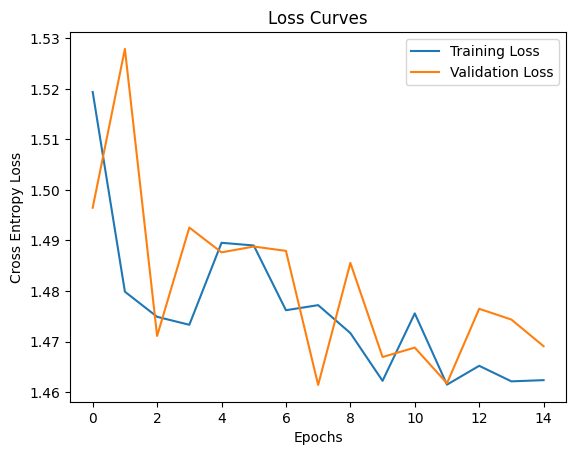

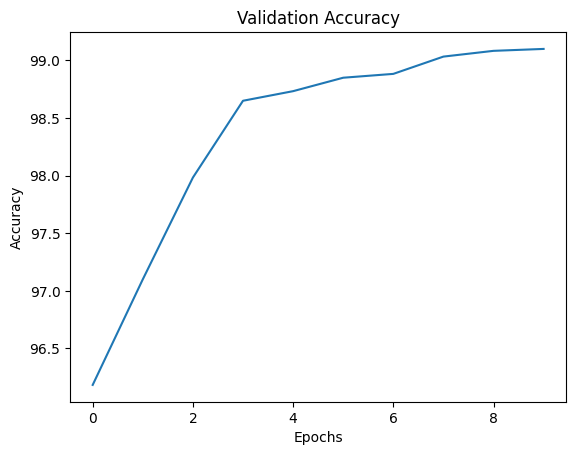

In [8]:
model_name = "ConvNet"
model_cfg = "default"
epochs = 15

model = convNet()
optim = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
criterion = nn.CrossEntropyLoss()
metric_meter = AvgMeter()
out_dir = f"{model_name}_{model_cfg}"
os.makedirs(out_dir, exist_ok=True)
train(model, optim, lr_sched, epochs=epochs, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

In [9]:
predictions = test(test_loader, model, criterion)

Test Error: 
 Accuracy: 99.3%, Avg loss: 1.470077 



## Visualizing random images

Here, we visualize randomly selected images along with their true and predicted labels.

True label is 7 and Predicted label is 7


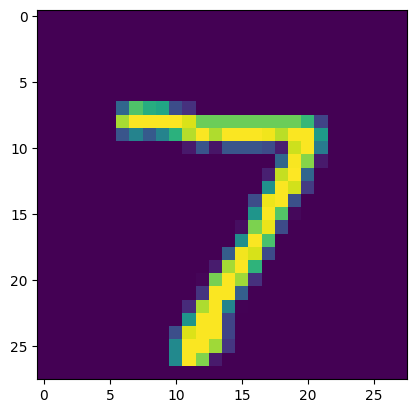

True label is 2 and Predicted label is 2


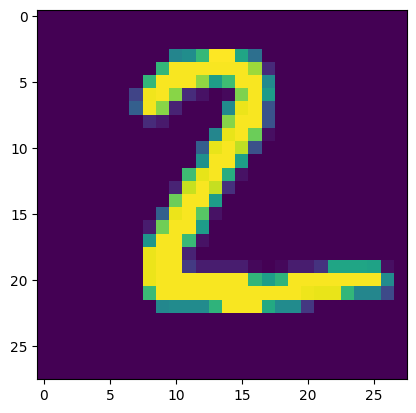

True label is 1 and Predicted label is 1


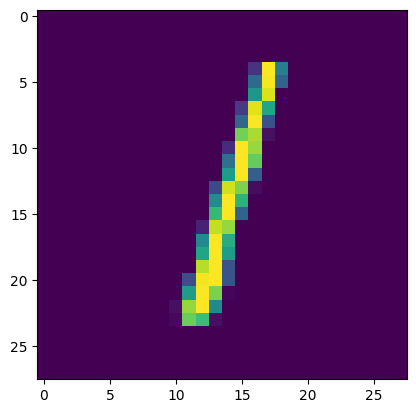

True label is 0 and Predicted label is 0


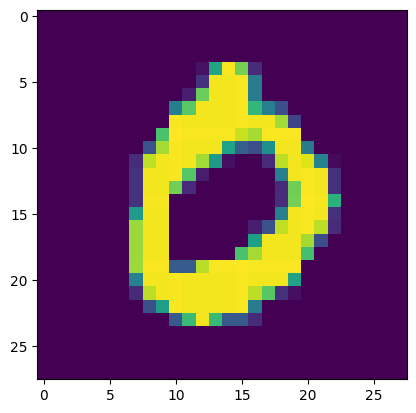

True label is 4 and Predicted label is 4


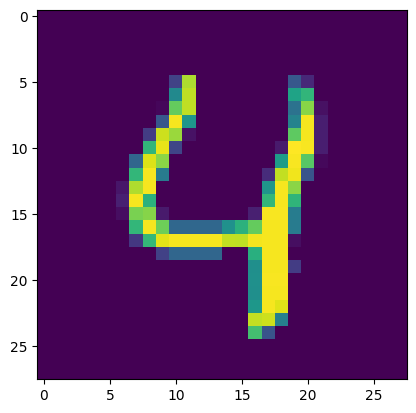

In [10]:
for i in range(5):
    img, true = next(iter(test_loader))
    print("True label is {} and Predicted label is {}".format(true[i], predictions[0][i].detach().numpy()[0]))
    plt.imshow(img[i].reshape(28,28).cpu())
    plt.show()

## Dimensions of the input and output at each layer

- `conv1` layer
  - **Input dimensions**: 28 x 28 x 1
  - **Output dimensions**: 28 x 28 x 32

- `maxpool1` layer
  - **Input dimensions**: 28 x 28 x 32
  - **Output dimensions**: 14 x 14 x 32

- `conv2` layer
  - **Input dimensions**: 14 x 14 x 32
  - **Output dimensions**: 14 x 14 x 32

- `maxpool2` layer
  - **Input dimensions**: 14 x 14 x 32
  - **Output dimensions**: 7 x 7 x 32

- `fc1` layer
  - **Input dimensions**: 7 x 7 x 32
  - **Output size**: 500

- `fc2` layer
  - **Input size**: 500
  - **Output size**: 10


## Parameters of the network

*Note*: Biases are included.

- `conv1` layer params = Number of weights + Number of biases = $(32*3*3) + 32$ = $320$

- `maxpool1` layer params = $0$

- `conv2` layer params = $(32*3*3*32) + 32$ = $9248$


- `maxpool2` layer params = $0$

- `fc1` layer params = $(500*7*7*32) + 500$ = $784500$

- `fc2` layer params = $(500*10) + 10$ = $5010$

Total parameters in fully connected layers = $789510$

Total parameters in convolution layers = $9568$

Total network parameters = $799078$

## Number of Neurons in the Network

*Note*: Not counting bias neurons.

- `input` layer neurons = $28*28*1$ = $784$

- `conv1` layer neurons = $28*28*32$ = $25088$

- `maxpool1` layer neurons = $14*14*32$ = $6272$ 

- `conv2` layer neurons = $14*14*32$ = $6272$

- `maxpool2` layer neurons = $7*7*32$ = $1568$

- `fc1` layer neurons = $500$

- `fc2` layer neurons = $10$

Total neurons in the network = $40494$

Total neurons in the fully connected layers = $510$

Total neurons in the convolutional layers (not including pooling layers) = $31360$ 

## Effects of Batch Normalization

Redefining architecture with batch normalization. As reference, https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216 has been used.

In [11]:
class batchnorm_convNet(nn.Module):
  def __init__(self):
    super(batchnorm_convNet, self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size = 3, stride = 1, padding = 1)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,32,kernel_size = 3, stride = 1, padding = 1)
    self.conv2_bn = nn.BatchNorm2d(32)
    self.fc1   = nn.Linear(7*7*32, 500)
    self.fc1_bn = nn.BatchNorm1d(500)
    self.fc2   = nn.Linear(500, 10)
    self.fc2_bn = nn.BatchNorm1d(10)
    self.activ = nn.ReLU()

  def pool(self, x, kernel_size = 2, stride = 2):
    out = F.max_pool2d(x, kernel_size, stride)
    return out

  def forward(self, x):
    out = self.activ(self.conv1_bn(self.conv1(x)))
    out = self.pool(out)
    out = self.activ(self.conv2_bn(self.conv2(out)))
    out = self.pool(out)
    out = out.view(out.size(0),-1)
    out = self.activ(self.fc1_bn(self.fc1(out)))
    out = self.fc2_bn(self.fc2(out))
    return F.softmax(out, dim = 1)

Now, training the batch normalized convolutional network.

Progress: [===================>] 100% [train loss] 1.52113 3 
Progress: [===================>] 100% [validation loss] 1.48553 [validation acc] 98.58333 3 
validation acc improved from 0 to 98.58333
Progress: [===================>] 100% [train loss] 1.48412 2 
Progress: [===================>] 100% [validation loss] 1.48011 [validation acc] 98.95000 0 
validation acc improved from 98.58333 to 98.95
Progress: [===================>] 100% [train loss] 1.48030 0 
Progress: [===================>] 100% [validation loss] 1.47938 [validation acc] 99.16667 7 
validation acc improved from 98.95 to 99.16667
Progress: [===================>] 100% [train loss] 1.47772 2 
Progress: [===================>] 100% [validation loss] 1.47860 [validation acc] 99.06667 7 
Progress: [===================>] 100% [train loss] 1.47585 5 
Progress: [===================>] 100% [validation loss] 1.47966 [validation acc] 99.13333 3 
Progress: [===================>] 100% [train loss] 1.47434 4 
Progress: [===============

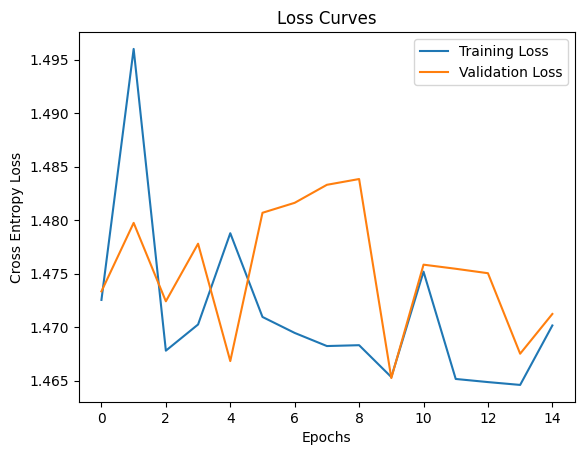

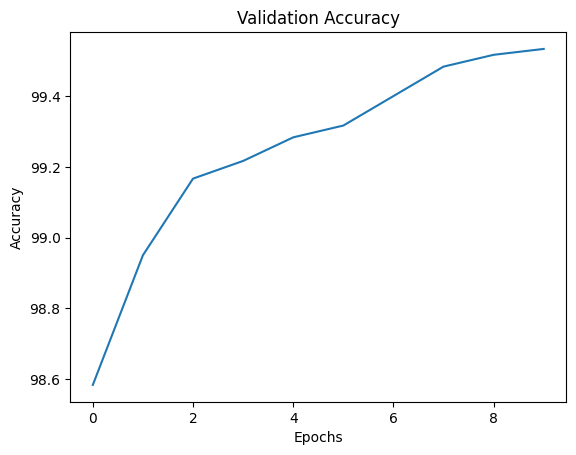

In [12]:
model_name = "ConvNet"
model_cfg = "Batch_Normalized"
epochs = 15

model2 = batchnorm_convNet()
optim = torch.optim.SGD(model2.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
criterion = nn.CrossEntropyLoss()
metric_meter = AvgMeter()
out_dir = f"{model_name}_{model_cfg}"
os.makedirs(out_dir, exist_ok=True)
train(model2, optim, lr_sched, epochs=epochs, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

Finding the test accuracy for batch normalized model.

In [13]:
predictions_bn = test(test_loader, model2, criterion)

Test Error: 
 Accuracy: 99.5%, Avg loss: 1.471659 



**Observations**

Upon using batch normalization,
- *Inference time* : The inference time increased minimally from 9.4 secs to 11.5 secs for the whole $10,000$ images in the test dataset without batching.
- *Training time* : The training time increased roughly by $1.35$ times from 184.9 secs to 250 secs.
- *Test Accuracy* : The test accuracy increased from $99.2$% to $99.5$%.

*Note*: The above runtimes were referred from cell runtime as shown by Visual Studio Code Jupyter environment. These figures may vary upon each runtime.

# Visualizing the Convolutional Neural Network

Used https://github.com/utkuozbulak/pytorch-cnn-visualizations#convolutional-neural-network-filter-visualization as reference.

##  `conv1` layer filters

torch.Size([3, 22, 42])


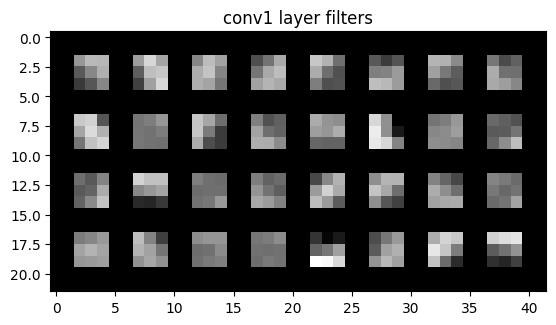

In [14]:
filter1 = model.conv1.weight.detach().clone().cpu()
filter1 = filter1 - filter1.min()
filter1 = filter1/filter1.max()
conv1_filters = make_grid(filter1)
print(conv1_filters.shape)
plt.imshow(conv1_filters.permute(1,2,0)) # Cannot plot images until you permute the dimensions
plt.title("conv1 layer filters")
plt.show()

## `conv2` layer filters

Since there are multiple (32) filters with depth 32, it makes sense to choose one of them and then visualize it at each depth value. Here, the 25th filter is chosen for illustration.

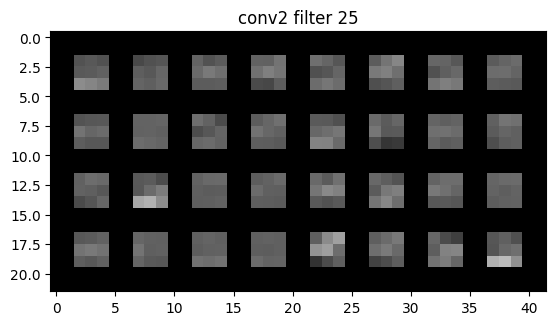

In [15]:
filter2 = model.conv2.weight.detach().clone().cpu()
filter2 = filter2 - filter2.min()
filter2 = filter2/filter2.max()

filter2_25 = filter2[26,:,:,:].reshape(32,1,3,3)
conv2_filter2_25 = make_grid(filter2_25)
plt.imshow(conv2_filter2_25.permute(1,2,0))
plt.title("conv2 filter 25")
plt.show()

From the above, it can be seen that the `conv1` layer filters have more variation in pixel intensity values which turn out to be more interpretable as compared to `conv2` layer filters.

## Visualizing activations of the convolution layers

This visualization helps us to see what neurons fire in a layer for a particular input, in a sense, this enables us to determine if the network is actually learning from the correct features or not. Another way to do this is occlusion study seen in the next section.

Here, let's check what happens for a number chosen at random.

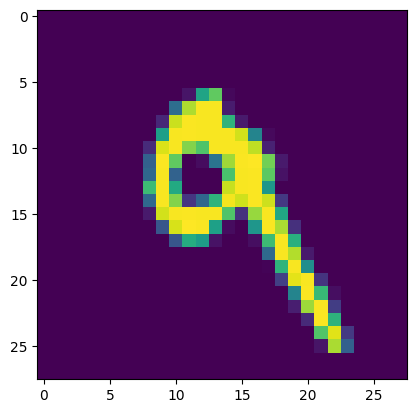

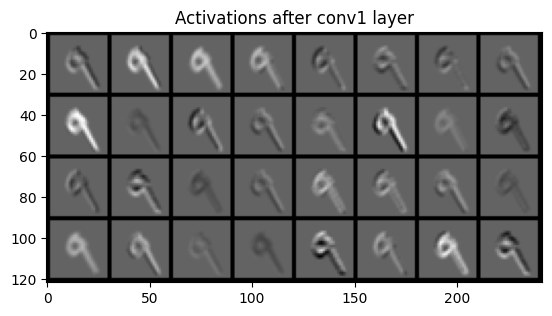

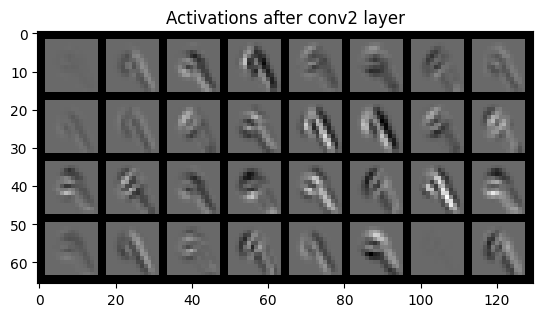

In [16]:
index = 7
test_im = test_loader.dataset.data[[index],:,:].clone()
test_img = test_im.reshape(1,1,28,28).clone().float()
plt.imshow(test_img[0].permute(1,2,0))
plt.show()

with torch.no_grad():
    conv1_out = model.conv1.forward(test_img).reshape(32,1,28,28)
    conv1_out = conv1_out.cpu()
    conv1_out = conv1_out - conv1_out.min()
    conv1_out = conv1_out/conv1_out.max()
    vis_conv1 = make_grid(conv1_out)
    plt.imshow(vis_conv1.permute(1,2,0))
    plt.title("Activations after conv1 layer")
    plt.show()

conv2_temp = model.conv1.forward(test_img)
conv2_temp = model.activ.forward(conv2_temp)
conv2_temp = model.pool(conv2_temp)
conv2_out = model.conv2.forward(conv2_temp)
conv2_out = conv2_out.cpu()
conv2_out = conv2_out - conv2_out.min()
conv2_out = conv2_out/conv2_out.max()
conv2_out = conv2_out.reshape(32,1,14,14)
vis_conv2 = make_grid(conv2_out)
plt.imshow(vis_conv2.permute(1,2,0))
plt.title("Activations after conv2 layer")
plt.show()


As we go deeper into the network, the activations become less discriminative and unreliable. In `conv2` filter activations, some of them have almost lost the activation capability.

## Occlusion

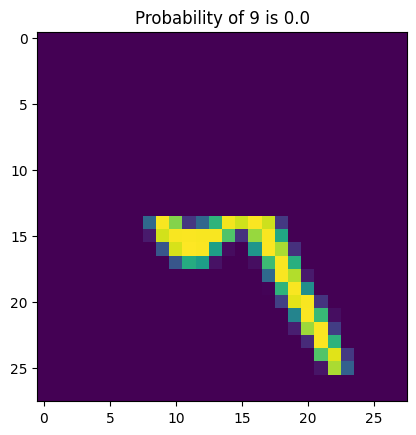

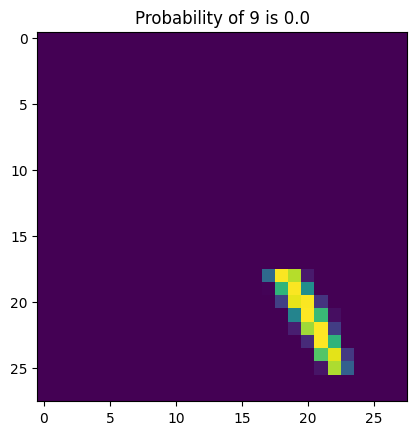

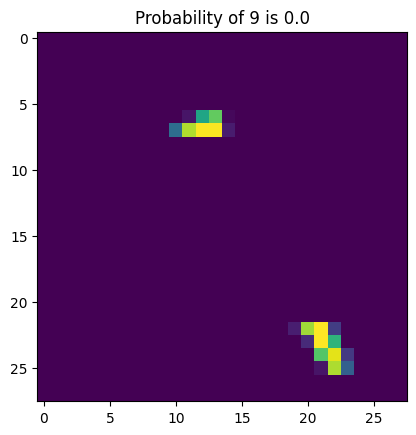

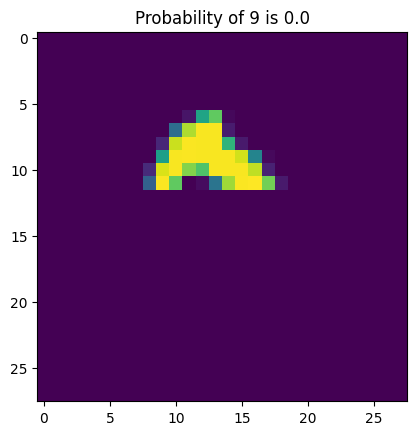

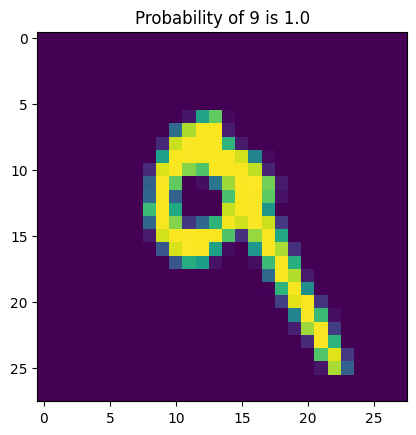

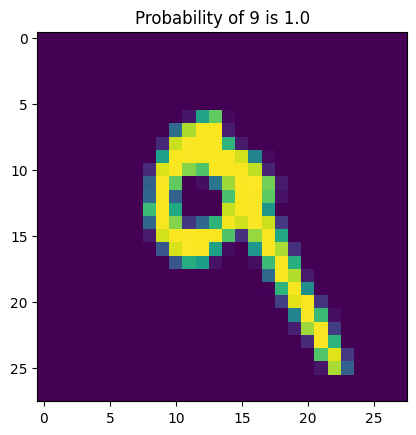

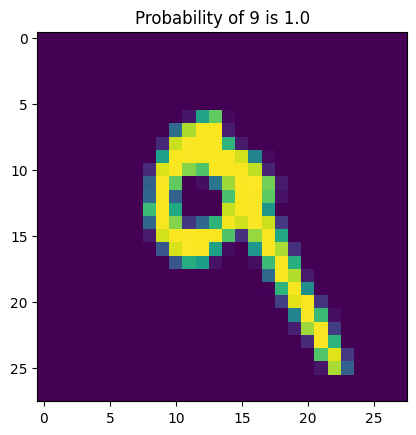

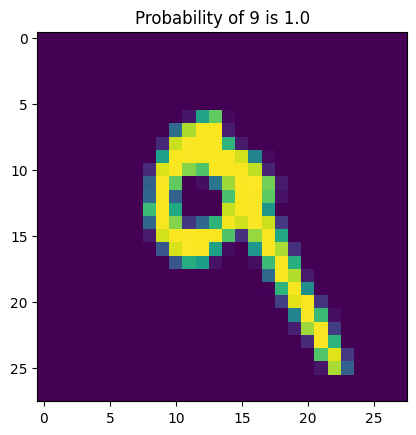

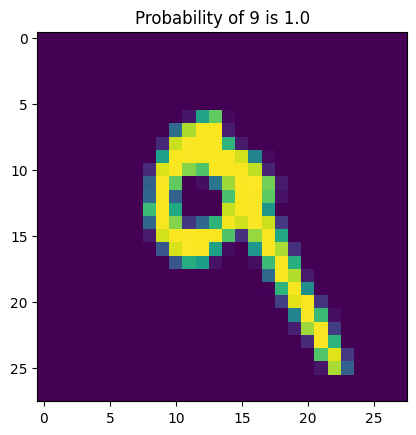

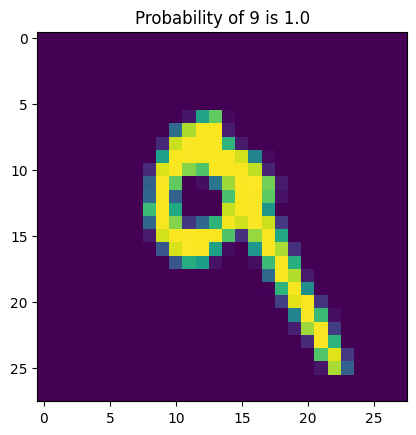

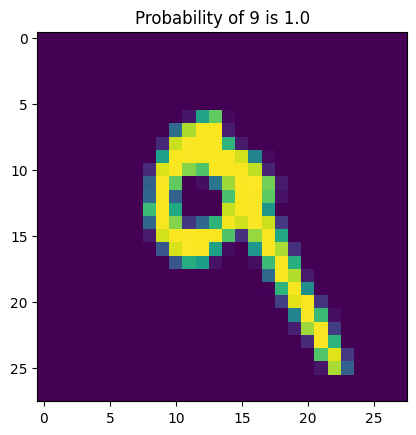

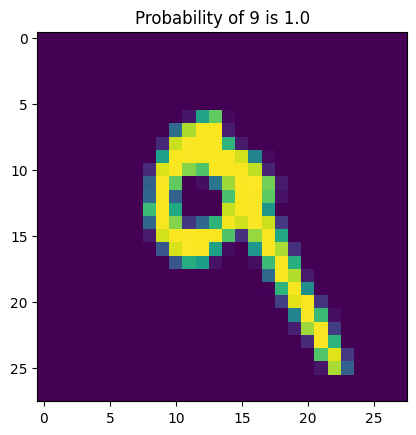

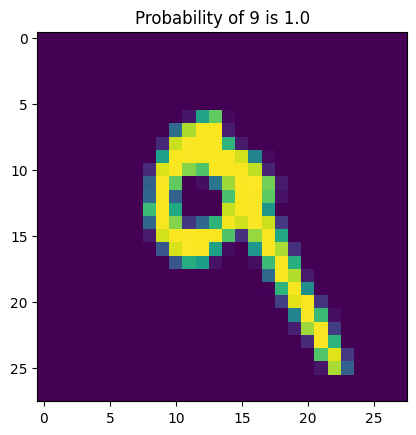

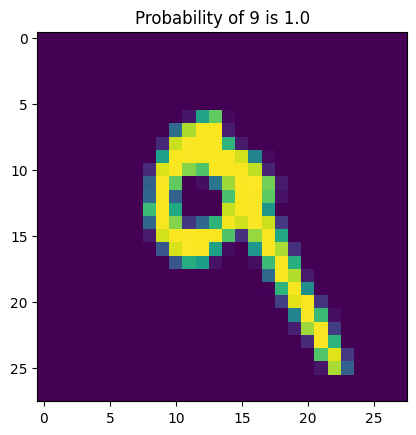

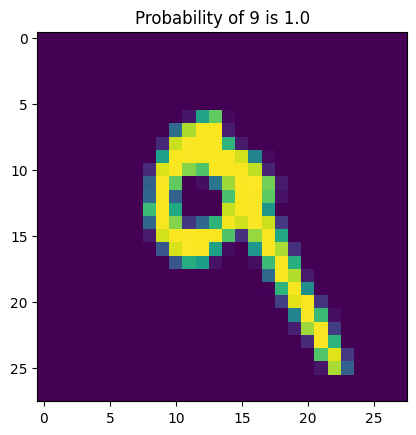

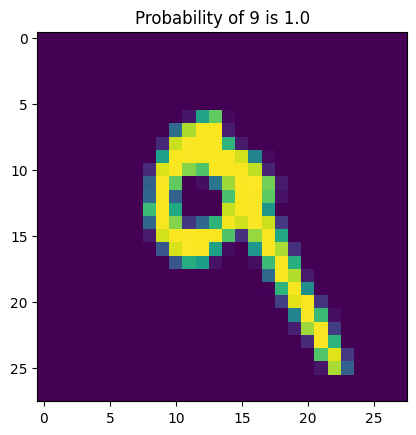

Probability Map for the class 9 as positive as patch is moved is shown below:
[[0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
Maximum Probable Class predicted as the patch is moved is shown below:
[[2. 2. 2. 2. 2. 7. 7.]
 [9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9.]]


In [17]:
dim = len(range(0,14,2))
prob_map = np.zeros((dim, dim), dtype = float)
max_prob_class_map = np.zeros_like(prob_map)
for y in range(0,14,2):
    for x in range(0,14,2):
        temp = test_im.clone()
        temp[y:y+14, x:x+14] = 0
        with torch.no_grad():
            temp = temp.clone().reshape(1,1,28,28).float()
        out = model.forward(temp, softmax = False)
        proba = F.softmax(out, dim=1).cpu().detach().numpy()
        pred = np.argmax(proba)
        prob = proba[:, 9]
        max_prob_class = pred
        prob_map[int(y/2), int(x/2)] = prob[0]
        max_prob_class_map[int(y/2), int(x/2)] = max_prob_class
        if ((x%4 == 0) & (y%4 == 0)):
            plt.imshow(temp.cpu().numpy().reshape(28, 28))
            plt.title("Probability of 9 is {}".format(prob[0]))
            plt.show()

print("Probability Map for the class 9 as positive as patch is moved is shown below:")
print(prob_map)
print("Maximum Probable Class predicted as the patch is moved is shown below:")
print(max_prob_class_map)

It can be noticed that when the patches are not occluding the part of the image where the digit is present, the prediction is done correctly. This simply indicates that the learning is *meaningful*.

# Adversarial Examples

## Non-Targeted Attack

Adversarial image of number 9: 	 for iteration : 0 	 logit value : [-133.3767]
Adversarial image of number 9: 	 for iteration : 500 	 logit value : [-58.176163]
Adversarial image of number 9: 	 for iteration : 1000 	 logit value : [27.487164]
Adversarial image of number 9: 	 for iteration : 1500 	 logit value : [127.514465]
Adversarial image of number 9: 	 for iteration : 2000 	 logit value : [253.94168]
Adversarial image of number 9: 	 for iteration : 2500 	 logit value : [391.0522]
Adversarial image of number 9: 	 for iteration : 3000 	 logit value : [542.7003]
Adversarial image of number 9: 	 for iteration : 3500 	 logit value : [690.73944]
Adversarial image of number 9: 	 for iteration : 4000 	 logit value : [842.67664]
Adversarial image of number 9: 	 for iteration : 4500 	 logit value : [1000.6319]
Adversarial image of number 9: 	 for iteration : 5000 	 logit value : [1156.9926]
Adversarial image of number 9: 	 for iteration : 5500 	 logit value : [1311.9209]
Adversarial image of

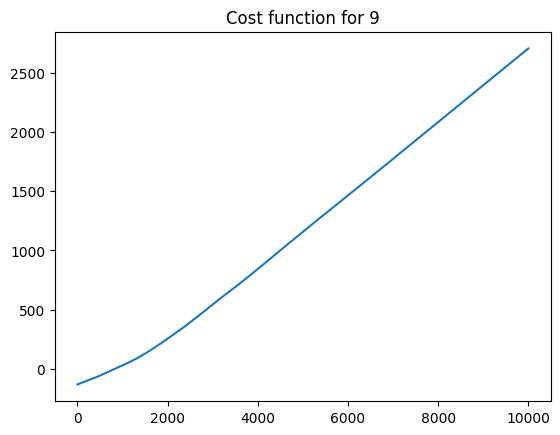

Adversarial image of number: 9 	 for iteration: 9999 	 logit value: [2707.0352]


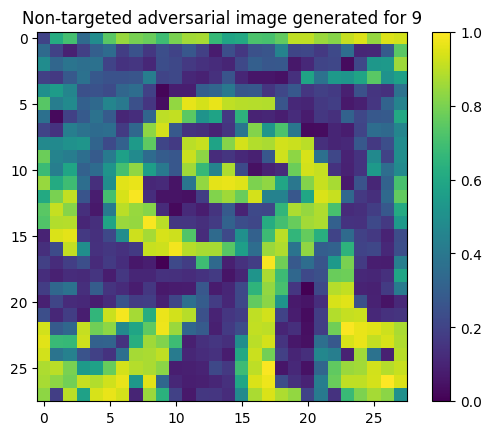

In [18]:
gauss_noise = np.random.normal(loc = 128, scale = 10, size = (28,28))
gaussian_noise = torch.from_numpy(gauss_noise).reshape(1,1,28,28).float()

logits = []
for i in range(10000):
    gaussian_noise = torch.autograd.Variable(gaussian_noise, requires_grad = True)
    out = model.forward(gaussian_noise, softmax = False)
    loss = out[:, 9]
    loss_index = loss.cpu().detach().numpy()
    logits.append(loss_index)
    if (i%500 == 0):
        print("Adversarial image of number 9: \t for iteration : {} \t logit value : {}".format(i, loss_index))
    loss.backward(retain_graph=True)
    d = torch.sign(gaussian_noise.grad.data)
    gaussian_noise = gaussian_noise + 0.01*d
plt.plot(np.asfarray(logits))
plt.title("Cost function for 9")
plt.show()

print("Adversarial image of number: 9 \t for iteration: {} \t logit value: {}".format(i, loss_index))
noise_kernel = gaussian_noise.cpu().reshape(28, 28).detach().numpy()
noise_kernel = noise_kernel - noise_kernel.min()
noise_kernel = noise_kernel/noise_kernel.max()
plt.imshow(noise_kernel)
plt.colorbar()
plt.title("Non-targeted adversarial image generated for 9")
plt.show()

- Cost function is monotonically increasing.
- Non-targeted adversarial image generated is barely recognizable as the given number.

## Targeted Attack

Let us see if we can make a generated image of number 2 to be classified as 9.

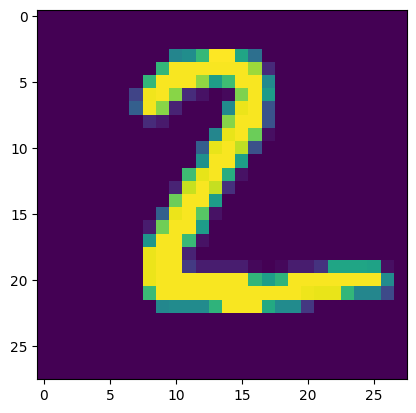

In [19]:
index = 1
target_im = test_loader.dataset.data[[index],:,:].clone()
target_img = target_im.reshape(1,1,28,28).clone().float()
plt.imshow(target_img[0].permute(1,2,0))
plt.show()

classify_as = 9

Iteration: 0	 Number: 2	 Classified with probability: [0.]	 MSE: 15214.5380859375

Iteration: 300	 Number: 2	 Classified with probability: [0.]	 MSE: 15134.3037109375

Iteration: 600	 Number: 2	 Classified with probability: [0.]	 MSE: 15100.6298828125

Iteration: 900	 Number: 2	 Classified with probability: [0.]	 MSE: 15076.3251953125

Iteration: 1200	 Number: 2	 Classified with probability: [5.9399147e-33]	 MSE: 15045.603515625

Iteration: 1500	 Number: 2	 Classified with probability: [0.82140255]	 MSE: 15020.6748046875

Iteration: 1800	 Number: 2	 Classified with probability: [1.]	 MSE: 15013.298828125

Iteration: 2100	 Number: 2	 Classified with probability: [1.]	 MSE: 15023.6669921875

Iteration: 2400	 Number: 2	 Classified with probability: [1.]	 MSE: 15038.8740234375

Iteration: 2700	 Number: 2	 Classified with probability: [1.]	 MSE: 15051.6611328125

Iteration: 2999	 Number: 2	 Classified with probability: [1.]	 MSE: 15066.8056640625



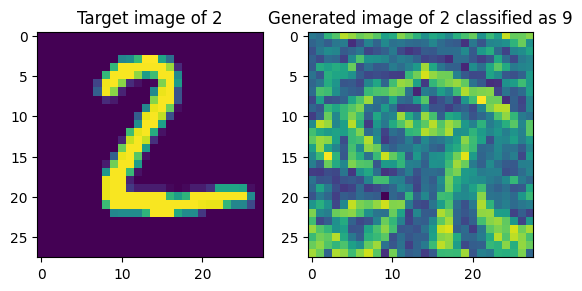

In [20]:
gauss_noise = np.random.normal(loc = 128, scale = 10, size = (28,28))
gaussian_noise = torch.from_numpy(gauss_noise).reshape(1,1,28,28).float()

for i in range(3000):
  gaussian_noise = torch.autograd.Variable(gaussian_noise, requires_grad = True)
  out = model.forward(gaussian_noise, softmax = False)
  probab = F.softmax(out, dim = 1)
  to_be_predicted_prob = probab[:,classify_as].cpu().detach().numpy()
  logit_value = out[:, classify_as]
  mse_error = F.mse_loss(gaussian_noise, target_img)
  mse_error_ = mse_error.cpu().detach().numpy()
  loss = logit_value - 0.001*mse_error
  if (i%300==0):
    print("Iteration: {}\t Number: 2\t Classified with probability: {}\t MSE: {}\n".format(i, to_be_predicted_prob, mse_error_))
  loss.backward(retain_graph = True)
  d = torch.sign(gaussian_noise.grad.data)
  gaussian_noise = gaussian_noise + 0.01*d
print("Iteration: {}\t Number: 2\t Classified with probability: {}\t MSE: {}\n".format(i, to_be_predicted_prob, mse_error_))
classified_img = gaussian_noise.cpu().reshape(28,28).detach().numpy()
classified_img = classified_img - classified_img.min()
classified_img = classified_img/classified_img.max()
f, ax = plt.subplots(1,2)
ax[0].imshow(target_img.cpu().reshape(28,28).numpy())
ax[0].set_title(f"Target image of 2")
ax[1].imshow(classified_img)
ax[1].set_title(f"Generated image of 2 classified as 9")
plt.show()

After 1000th iteration, the classification probability changes to 1. The generated image on visual inspection looks close to 9 as opposed to 2.

## Adding Noise

After adding noise, 2 should be classified as 9.

Iteration: 0	 target: 9	 probability: [0.]	 Logit Value: [-139.29736]
Iteration: 5	 target: 9	 probability: [0.]	 Logit Value: [-135.44395]
Iteration: 10	 target: 9	 probability: [0.]	 Logit Value: [-131.52563]
Iteration: 15	 target: 9	 probability: [0.]	 Logit Value: [-127.610634]
Iteration: 20	 target: 9	 probability: [0.]	 Logit Value: [-123.867516]
Iteration: 25	 target: 9	 probability: [0.]	 Logit Value: [-120.23642]
Iteration: 30	 target: 9	 probability: [0.]	 Logit Value: [-116.76057]
Iteration: 35	 target: 9	 probability: [0.]	 Logit Value: [-113.39561]
Iteration: 40	 target: 9	 probability: [0.]	 Logit Value: [-110.11674]
Iteration: 45	 target: 9	 probability: [0.]	 Logit Value: [-106.84342]
Iteration: 50	 target: 9	 probability: [0.]	 Logit Value: [-103.55428]
Iteration: 55	 target: 9	 probability: [0.]	 Logit Value: [-100.27409]
Iteration: 60	 target: 9	 probability: [0.]	 Logit Value: [-97.05401]
Iteration: 65	 target: 9	 probability: [0.]	 Logit Value: [-93.82016]
Iteratio

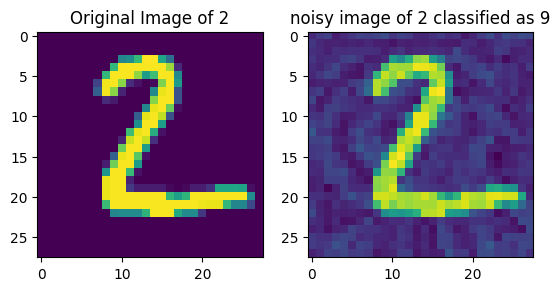

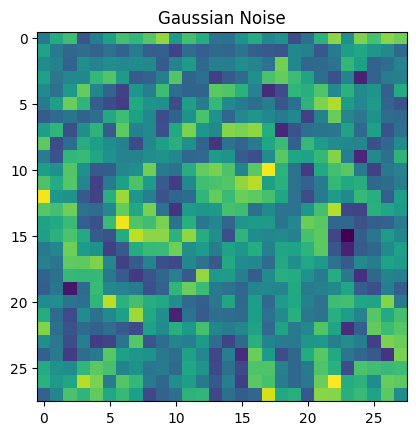

In [21]:
# list of indices to refer to each image class
indices = [3, 2, 1, 18, 4, 23, 11, 0, 61, 7]

orig_input = 2
target_input = 9

image = test_loader.dataset.data[indices[orig_input], :, :].clone().reshape(1,1,28,28).float()  
gauss_noise = np.random.normal(loc = 128, scale = 10, size = (28,28))
gaussian_noise = torch.from_numpy(gauss_noise).reshape(1,1,28,28).float()
prob = 0
highest_prob = orig_input
iter = 0
while(highest_prob!=target_input):
  gaussian_noise = torch.autograd.Variable(gaussian_noise, requires_grad = True)
  out = model.forward(gaussian_noise, softmax = False)
  probab = F.softmax(out, dim = 1).cpu().detach().numpy()
  highest_prob = int(np.argmax(probab))
  prob = probab[:, target_input]
  loss = out[:, target_input]
  loss_op = loss.cpu().detach().numpy()
  if (iter%5==0):
    print("Iteration: {}\t target: {}\t probability: {}\t Logit Value: {}".format(iter, target_input, prob, loss_op))
  loss.backward(retain_graph = True)
  d = torch.sign(gaussian_noise.grad.data)
  d = d - d.min()
  d = d/d.max()
  gaussian_noise = gaussian_noise + 0.1*d
  iter = iter+1

print("Iteration: {}\t target: {}\t probability: {}\t Logit Value: {}".format(iter, target_input, prob, loss_op))
noisy_image = (gaussian_noise + image).cpu().reshape(28,28).detach().numpy()
noisy_image = noisy_image - noisy_image.min()
noisy_image = noisy_image/noisy_image.max()
f, ax = plt.subplots(1,2)
ax[0].imshow(image.cpu().reshape(28,28).numpy())
ax[0].set_title(f"Original Image of {orig_input}")
ax[1].imshow(noisy_image)
ax[1].set_title(f"noisy image of {orig_input} classified as {target_input}")
plt.show()

#Displaying the Gaussian Noise
gaussian = (gaussian_noise).cpu().reshape(28,28).detach().numpy()
gaussian = gaussian - np.min(gaussian)
gaussian = gaussian/np.max(gaussian)
plt.imshow(gaussian)
plt.title(f"Gaussian Noise")
plt.show()

We see that the noisy image with added gaussian noise obtained through multiple iterations can be used to fool the network into classifying an arbitrary class instance as another class.